In [43]:
import torchvision.models as models
import transformers
from torchvision import transforms
import torch
import  os
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
device = "cpu"
model = models.mobilenet_v3_small(pretrained=False)
model.classifier[3] = torch.nn.Linear(1024, 768)
model.load_state_dict(torch.load(
    '/kaggle/input/mobilenet_student_model/pytorch/default/1/mobilenet_v3_small_distilled_new_state_dict.pth', map_location=device))

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
model.eval()

<ipython-input-5-64056fd5cae8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [37]:
teacher_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to("cpu")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

teacher_model.eval() 

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [32]:
def time_inference(model_func, image_path, iterations=10):
    times = []
    
    _ = model_func(image_path)

    for _ in range(iterations):
        start_time = time.perf_counter()
        _ = model_func(image_path)
        end_time = time.perf_counter()
        times.append(end_time - start_time)

    return sum(times) / len(times)  

In [38]:
def get_mobilenet_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        embedding = model(input_tensor)
    
    return F.normalize(embedding, p=2, dim=1).squeeze(0).cpu().numpy()


def get_clip_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        embedding = teacher_model.get_image_features(**inputs) 

    return torch.nn.functional.normalize(embedding, p=2, dim=1).squeeze(0).cpu().numpy()


In [47]:
sample_image='/kaggle/input/coco-2017-val-dataset/val2017/000000000285.jpg'
mobilenet_time = time_inference(get_mobilenet_embedding, sample_image)
clip_time = time_inference(get_clip_embedding, sample_image)

print(f"MobileNetV3-Small average inference time: {mobilenet_time:.4f} seconds")
print(f"CLIP average inference time: {clip_time:.4f} seconds")

MobileNetV3-Small average inference time: 0.0314 seconds
CLIP average inference time: 1.9046 seconds


In [48]:
reduction_percentage = ((clip_time - mobilenet_time) / clip_time) * 100
print(f"MobileNetV3 reduces inference time by {reduction_percentage:.2f}% compared to CLIP.")

MobileNetV3 reduces inference time by 98.35% compared to CLIP.


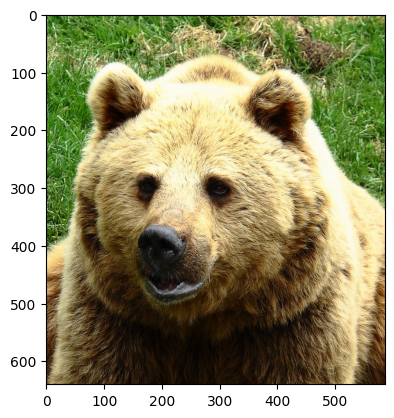

In [49]:
img=Image.open('/kaggle/input/coco-2017-val-dataset/val2017/000000000285.jpg')
plt.imshow(img)
plt.show()